출처 : https://github.com/redpineK/deeplearning 

poloclub.github.io/ganlab/ 의 프로그램을 코드로 간단 구현

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [ ]:
# 생성자(Generator) 모델 생성 함수
#
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))

    return model

In [ ]:
# 판별자(Discriminator) 모델 생성 함수
# 
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# 생성자와 판별자를 연결한 GAN 모델 생성 함부
#
def build_gan(generator, discriminator): # 통합네트워크 설정
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# 판별자 모델 생성 (Compile)
#
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(),
                      metrics=['accuracy'])
discriminator.summary()
## trainable 파라미터 확인
#
# Model: "sequential"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  flatten (Flatten)           (None, 784)               0         
                                                                 
#  dense (Dense)               (None, 128)               100480    
                                                                 
#  leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
#  dense_1 (Dense)             (None, 1)                 129       
                                                                 
# =================================================================
# Total params: 100,609
# Trainable params: 100,609
# Non-trainable params: 0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GAN 모델 생성 (Compile)
generator = build_generator(img_shape, z_dim)
discriminator.trainable = False # 뒷부분은 바뀌지 않게 고정
gan = build_gan(generator, discriminator) # 통합
gan.compile(loss='binary_crossentropy', optimizer=Adam())

print("생성자 모델 ==========")
generator.summary()

# Trainable 파라미터 확인
#

생성자 모델 ==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("판별자 모델 ======== ")
discriminator.summary()

판별자 모델 ======== 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________


In [ ]:
print("GAN 모델 ==================")
gan.summary(())

GAN 모델 ==================
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         114064    
                                                                 
 sequential (Sequential)     (None, 1)                 100609    
                                                                 
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


In [ ]:
# 판별자와 생성자를 훈련시키기 위한 함수
# 판별자 : 실제 이미지(real)와 생성 이미지(fake)를 구분하도록 훈련
# GAN    : 생성자가 생성한 이미지가 실제 이미지가 되도록 훈련
#
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # discriminator.summary()
    
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)


In [ ]:
# 생성자에 의해 생성된 이미지 확인
#
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


훈련

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.026925, acc.: 100.00%] [G loss: 4.224903]
2000 [D loss: 0.210984, acc.: 90.23%] [G loss: 5.211923]
3000 [D loss: 0.158166, acc.: 94.53%] [G loss: 4.313338]
4000 [D loss: 0.174582, acc.: 93.75%] [G loss: 5.558262]
5000 [D loss: 0.149210, acc.: 93.36%] [G loss: 4.099965]
6000 [D loss: 0.336197, acc.: 87.89%] [G loss: 3.851605]
7000 [D loss: 0.231390, acc.: 90.62%] [G loss: 4.775196]
8000 [D loss: 0.537192, acc.: 78.91%] [G loss: 3.488171]
9000 [D loss: 0.524360, acc.: 79.69%] [G loss: 3.971777]
10000 [D loss: 0.422347, acc.: 81.64%] [G loss: 3.600910]
11000 [D loss: 0.705025, acc.: 70.31%] [G loss: 2.792885]
12000 [D loss: 0.293686, acc.: 87.89%] [G loss: 3.541456]
13000 [D loss: 0.597741, acc.: 75.78%] [G loss: 2.992167]
14000 [D loss: 0.462819, acc.: 80.86%] [G loss: 2.677955]
15000 [D loss: 0.597885, acc.: 76.17%] [G loss: 2.823618]
16000 [D loss: 0.436869, acc.: 80.86%] [G loss: 2.990742]
17000 [D loss: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


22000 [D loss: 0.237670, acc.: 87.50%] [G loss: 3.905411]
23000 [D loss: 0.303275, acc.: 87.89%] [G loss: 2.571620]
24000 [D loss: 0.379140, acc.: 82.42%] [G loss: 2.690887]
25000 [D loss: 0.392986, acc.: 82.03%] [G loss: 2.666388]
26000 [D loss: 0.308103, acc.: 88.28%] [G loss: 2.765551]
27000 [D loss: 0.260268, acc.: 87.50%] [G loss: 2.382967]
28000 [D loss: 0.297382, acc.: 87.89%] [G loss: 2.896127]
29000 [D loss: 0.299977, acc.: 87.50%] [G loss: 2.913792]
30000 [D loss: 0.489049, acc.: 76.56%] [G loss: 2.190694]
31000 [D loss: 0.475841, acc.: 78.12%] [G loss: 2.407938]
32000 [D loss: 0.439550, acc.: 78.52%] [G loss: 2.487716]
33000 [D loss: 0.441761, acc.: 77.73%] [G loss: 2.055535]
34000 [D loss: 0.386257, acc.: 83.98%] [G loss: 2.413398]
35000 [D loss: 0.409517, acc.: 83.59%] [G loss: 2.646802]
36000 [D loss: 0.352395, acc.: 85.94%] [G loss: 2.575482]
37000 [D loss: 0.363542, acc.: 83.98%] [G loss: 2.597325]
38000 [D loss: 0.287887, acc.: 89.06%] [G loss: 2.578299]
39000 [D loss:

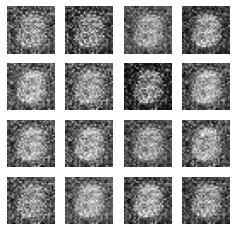

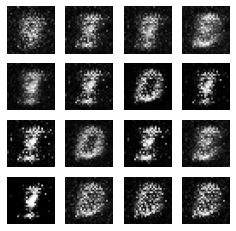

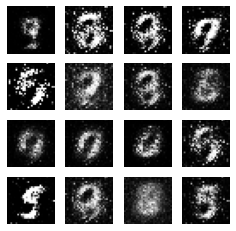

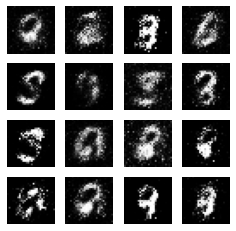

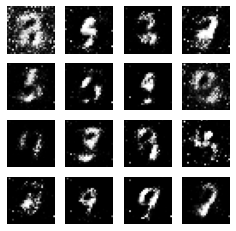

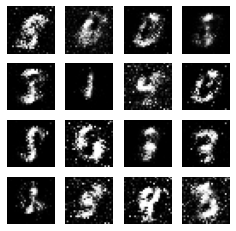

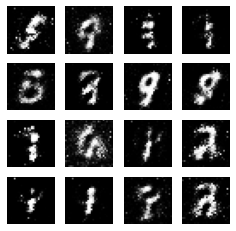

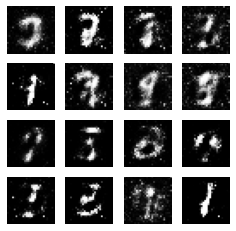

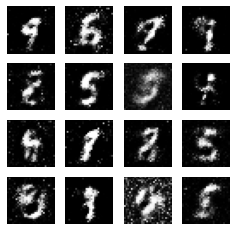

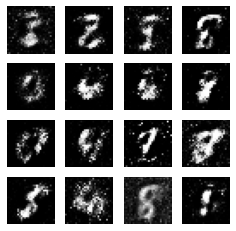

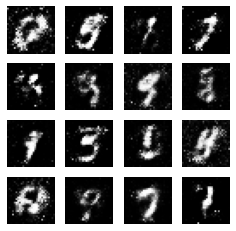

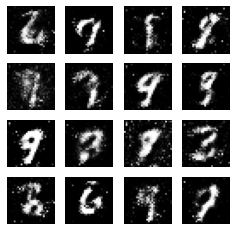

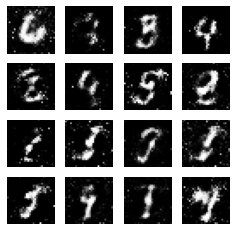

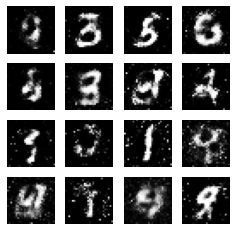

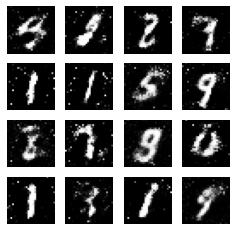

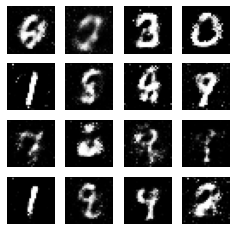

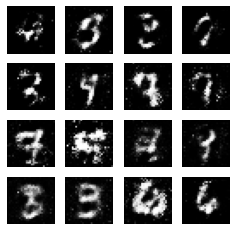

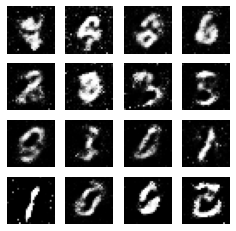

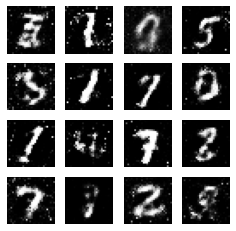

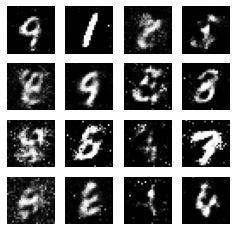

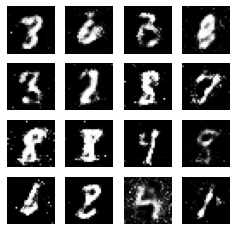

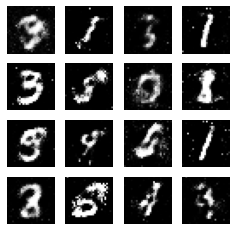

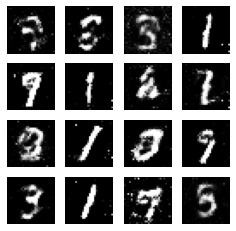

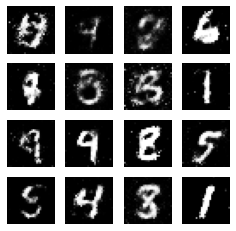

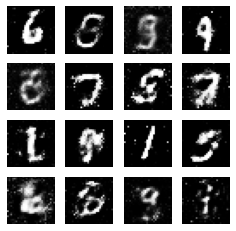

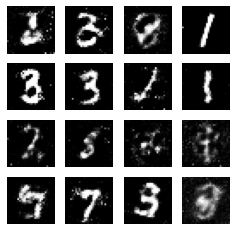

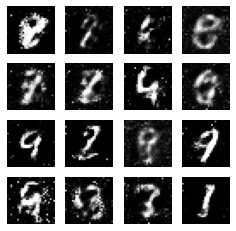

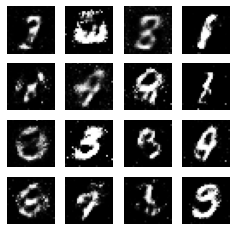

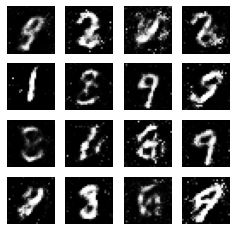

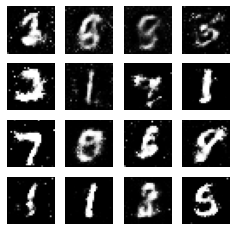

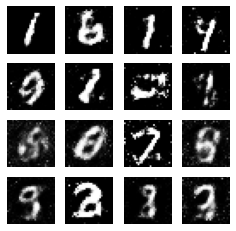

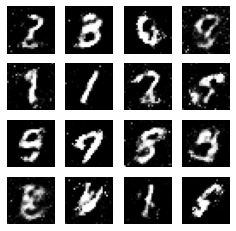

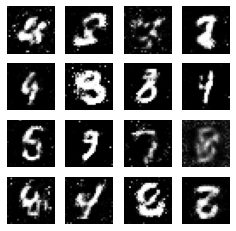

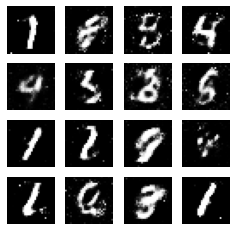

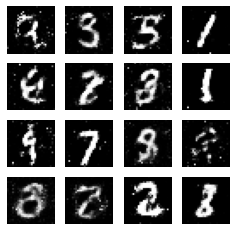

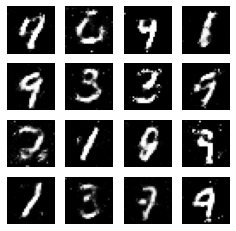

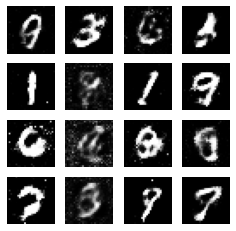

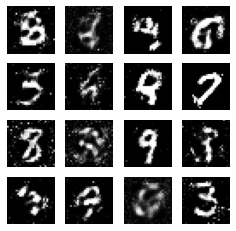

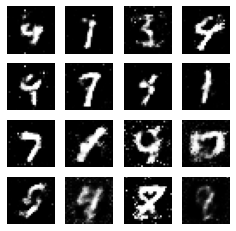

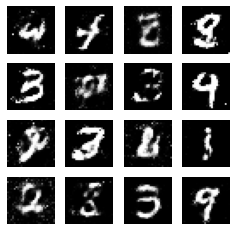

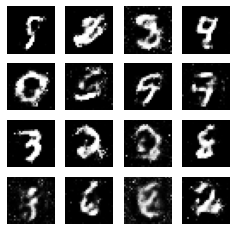

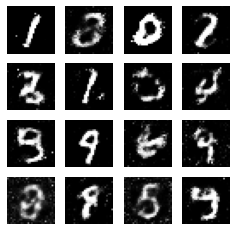

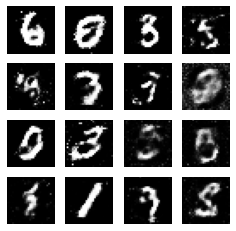

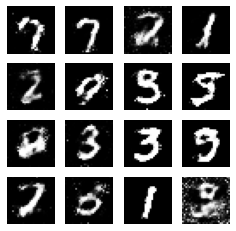

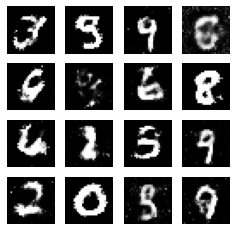

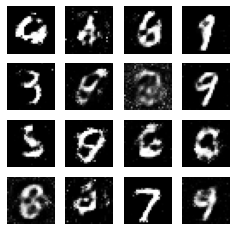

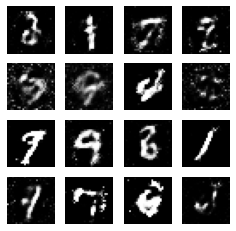

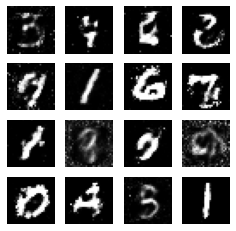

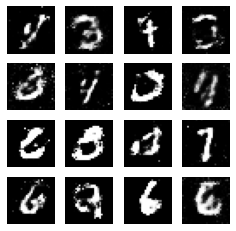

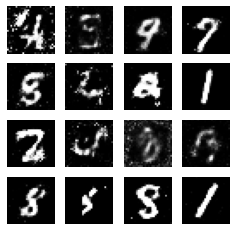

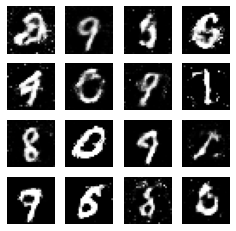

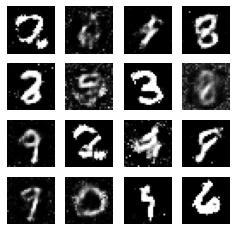

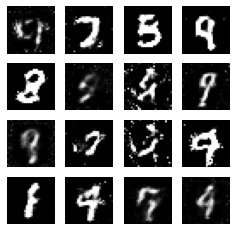

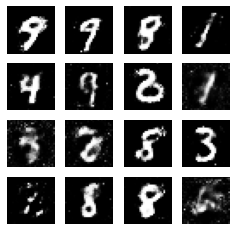

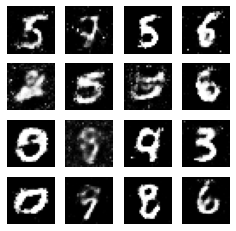

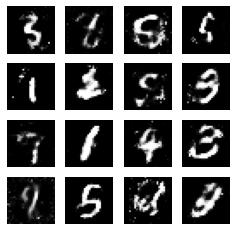

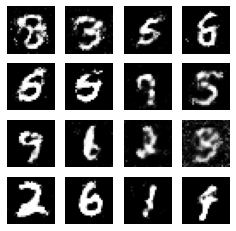

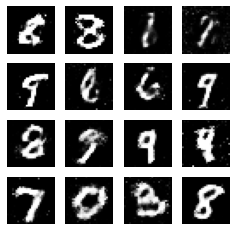

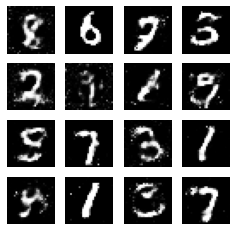

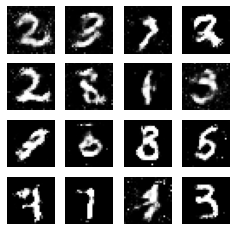

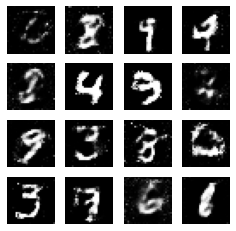

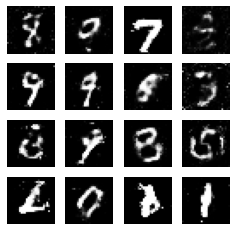

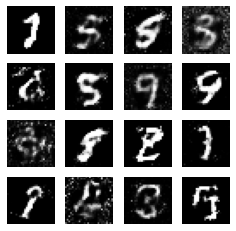

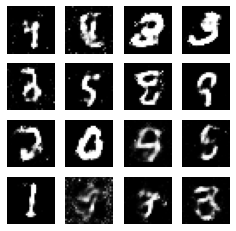

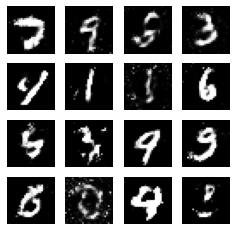

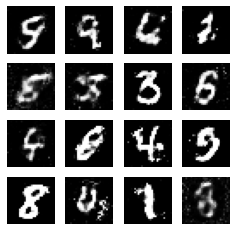

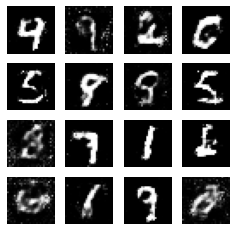

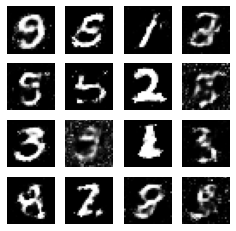

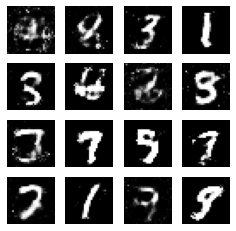

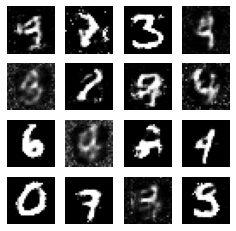

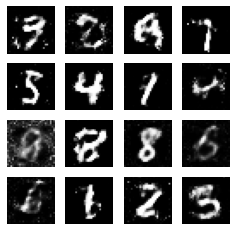

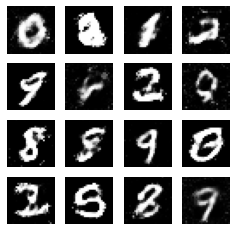

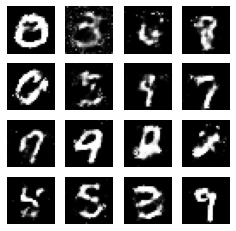

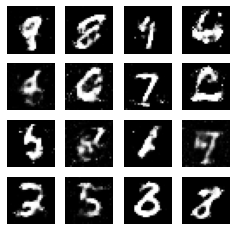

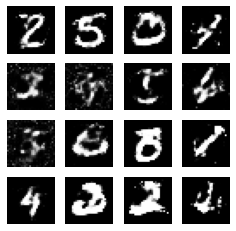

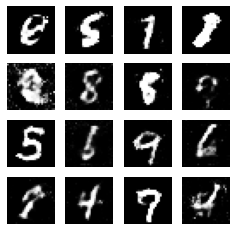

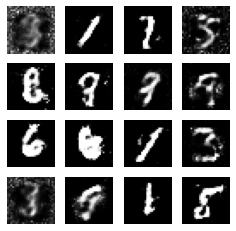

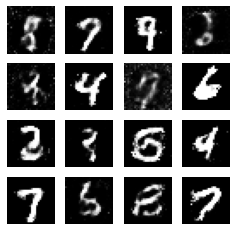

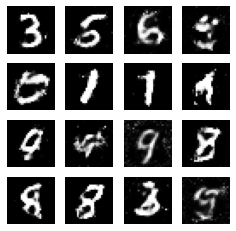

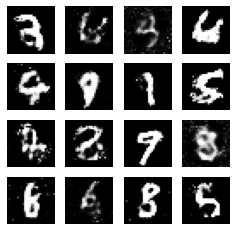

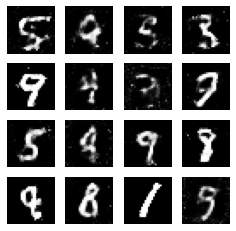

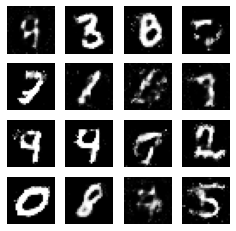

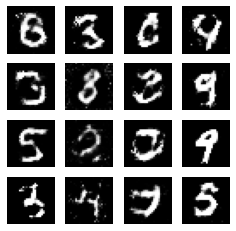

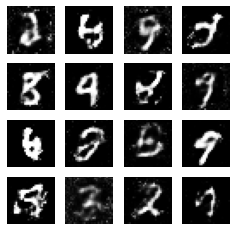

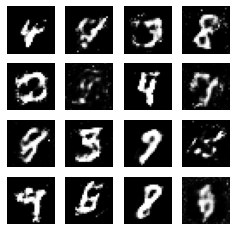

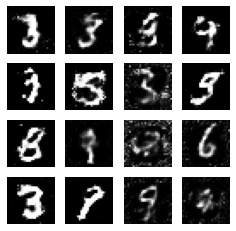

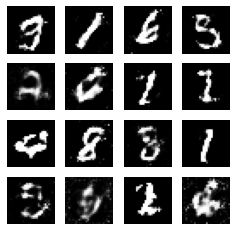

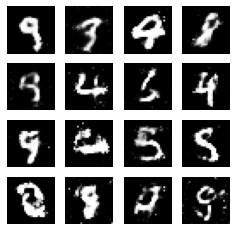

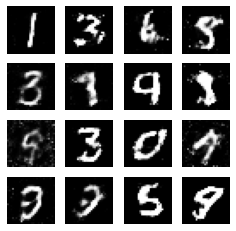

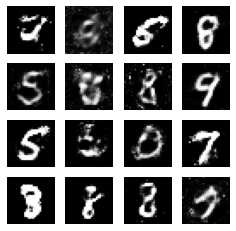

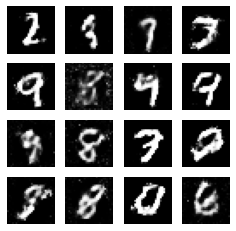

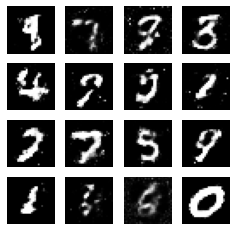

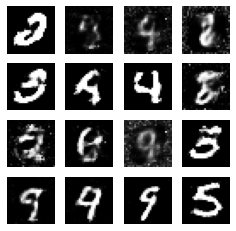

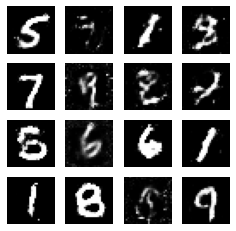

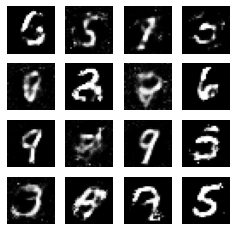

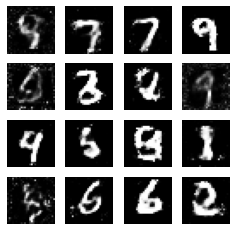

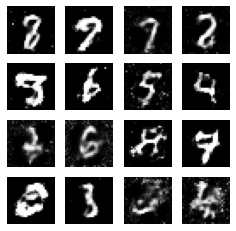

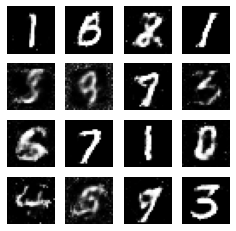

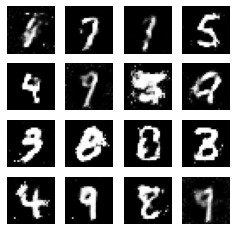

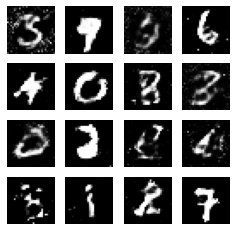

In [ ]:
# 훈련
iterations = 100000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [ ]:

losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [ ]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()